# Splines

In [1]:
import abc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from patsy import dmatrix
from math import sqrt

%matplotlib inline

To play and learn about splines, we are going to use the [ironslag](https://rdrr.io/cran/DAAG/man/ironslag.html) dataset. It contains 53 rows and 2 columns. Two methods for measuring the iron content in samples of slag were compared, a chemical and a magnetic method. The chemical method requires greater effort than the magnetic method.

In [2]:
# Read dataset and remove first index column
df = pd.read_csv('ironslag.csv')
df = df.iloc[:, 1:]

x = df.values[:, 0]
y = df.values[:, 1]

x_train, x_test, y_train, y_test = train_test_split(x, y)
data = (x_train, y_train, x_test, y_test)

df.head()

,chemical,magnetic
0,24,25
1,16,22
2,24,17
3,18,21
4,18,20


## Models

We are going to compare how the different models seen in the lecture fit this data: Linear Regression, Polynomial Regression and Splines. Also, first of all we are going a helper class to inherit it and keep adding new functionalities avoiding to repeat unnecessary code many times such as functions to draw plots, print error...

In [3]:
class Model():
    def __init__(self, data):
        x_train, y_train, x_test, y_test = data
        self.x_train = x_train.reshape(-1, 1)
        self.y_train = y_train
        self.x_test = x_test.reshape(-1, 1)
        self.y_test = y_test
        
        self.min_x = min([min(x_train), min(x_test)])
        self.max_x = max([max(x_train), max(x_test)])
        
        self.model = self.create()
        self.fit()
        
    @abc.abstractmethod
    def create(self):
        return
    
    @abc.abstractmethod
    def fit(self):
        return
    
    @abc.abstractmethod
    def predict(self, v):
        return
    
    @abc.abstractmethod
    def display_coefficients(self):
        pass
    
    def plot_base_data(self, mode='train', color='blue', marker='o',
                     title='Iron content measuraments with chemical vs magnetic methods',
                     x_axis_label='Chemical method',
                     y_axis_label='Magnetical method',
                     fig_shape=None,
                     end_plot=False):
        if fig_shape is not None:
            r, c, i = fig_shape
            plt.subplot(r, c, i)
        if mode == 'train':
            plt.scatter(self.x_train, self.y_train, color=color, marker=marker)
        else:
            plt.scatter(self.x_test, self.y_test, color=color, marker=marker)
        plt.title(title)
        plt.xlabel(x_axis_label)
        plt.ylabel(y_axis_label)
        if end_plot:
            plt.show()
            
    def plot_prediction_line(self, steps=100, color='red', end_plot=False):
        x = np.linspace(self.min_x, self.max_x, steps).reshape(-1, 1)
        y = self.predict(x)
        plt.plot(x, y, '-', color=color)
        if end_plot:
            plt.show()
        
    def get_error(self, mode='test', display=True):
        if mode == 'train':
            y = self.predict(self.x_train)
            rms = sqrt(mean_squared_error(self.x_train, y))
        else:
            y = self.predict(self.x_test)
            rms = sqrt(mean_squared_error(self.x_test, y))

        if display:
            print('RMSE in {} data = {}'.format(mode, rms))
        return rms

### Linear Regression

Easiest one, with the form `Y = w0 + w1*X`. Main problem? Underfitting:

In [4]:
class LinearModel(Model):
    def create(self):
        return LinearRegression()
        
    def fit(self):
        self.model.fit(self.x_train, self.y_train)
        
    def predict(self, x):
        return self.model.predict(x)
    
    def display_coefficients(self):
        msg = 'Y = {:.4f}'.format(self.model.intercept_)
        for coef in self.model.coef_:
            msg += ' + {:.4f}*X'.format(coef)
        print(msg)

Y = 3.5794 + 0.8187*X
RMSE in train data = 0.9400651043772605
RMSE in test data = 0.9402319966819114


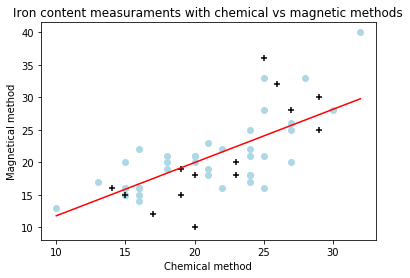

In [5]:
linear_model = LinearModel(data)
linear_model.display_coefficients()
linear_model.plot_base_data('train', color='lightblue', marker='o')
linear_model.plot_base_data('test', color='black', marker='+')
linear_model.plot_prediction_line()
_ = linear_model.get_error('train')
_ = linear_model.get_error('test')

### Polynomial Regression

Non-linear one, with the form `Y = w0 + w1*X + ... + wn*X^n`. Main problem? Such curves lead to overfitting with high degree polynomials. We can also note that even `Polyfit` library warns us that our model is poorly conditioned.

In [6]:
class PolynomialModel(Model):
    def __init__(self, data, degree=2):
        self.degree = degree
        super().__init__(data)
    
    def create(self):
        x = self.x_train.reshape(-1)
        weights = np.polyfit(x, self.y_train, self.degree)
        return np.poly1d(weights)
    
    def predict(self, x):
        return self.model(x)
    
    def display_coefficients(self):
        msg = 'Y = {:.4f}'.format(self.model.coeffs[-1])
        for i, coef in enumerate(self.model.coeffs[1::-1]):
            msg += ' + {:.4f}*X^{}'.format(coef, i + 1)
        print(msg)

Y = 24.9226 + -1.3412*X^1 + 0.0515*X^2
RMSE in train data = 1.7484720041602109
RMSE in test data = 1.2613394543696106


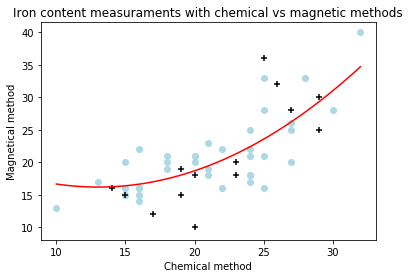

In [7]:
polynomial_model = PolynomialModel(data, degree=2)
polynomial_model.display_coefficients()
polynomial_model.plot_base_data('train', color='lightblue', marker='o')
polynomial_model.plot_base_data('test', color='black', marker='+')
polynomial_model.plot_prediction_line()
_ = polynomial_model.get_error('train')
_ = polynomial_model.get_error('test')

/Users/josepdecidrodriguez/anaconda3/envs/MLDL/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/Users/josepdecidrodriguez/anaconda3/envs/MLDL/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/Users/josepdecidrodriguez/anaconda3/envs/MLDL/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/Users/josepdecidrodriguez/anaconda3/envs/MLDL/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


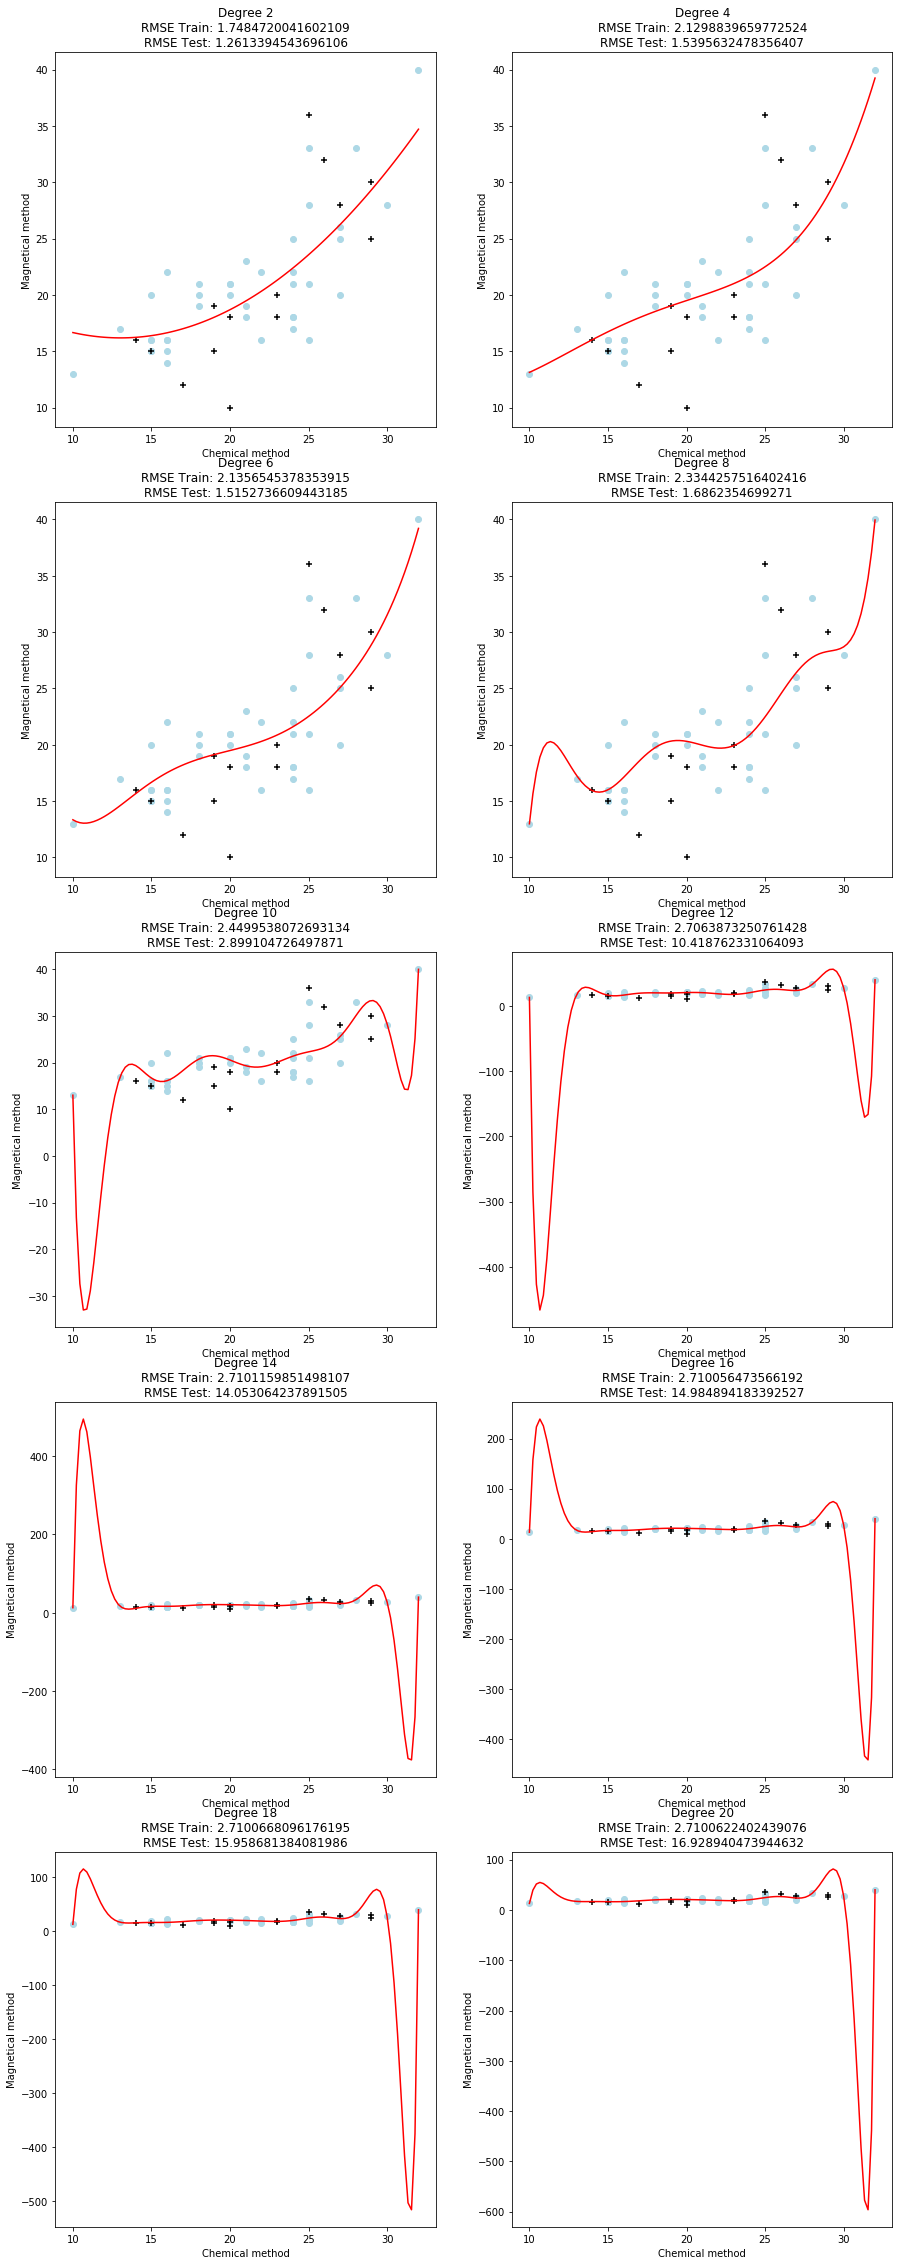

In [8]:
# Fitting and displaying the lines for polynomials of degree 2 up to 20 (step 2)

plt.figure(figsize=(15, 40))

for i, d in enumerate(range(2, 21, 2)):
    polynomial_model = PolynomialModel(data, degree=d)
    
    train_err = polynomial_model.get_error('train', display=False)
    test_err = polynomial_model.get_error('test', display=False)
    
    title = 'Degree {}\nRMSE Train: {}\nRMSE Test: {}'.format(d, train_err, test_err)
    
    polynomial_model.plot_base_data('train', title=title, color='lightblue', marker='o', fig_shape=(5, 2, i+1))
    polynomial_model.plot_base_data('test', title=title, color='black', marker='+')
    polynomial_model.plot_prediction_line()

### Piecewise

The main idea of splines for regression is to divide the dataset into multiple bins and fits each bin with a separate model. Each point where a division occurs is known as a **Knot**. K different knots through the domain of X, will end up fitting K+1 different models.

In [9]:
class PiecewiseModel(Model):
    def __init__(self, data, degree=3, knots=(25, 50, 75)):
        self.degree = degree
        self.knots = knots
        self.k = len(knots)
        super().__init__(data)
    
    def create(self):
        x_data, x_dummy = self.convert_to_dummy(self.x_train)
        return sm.GLM(x_data, x_dummy).fit()    
    
    def predict(self, x):
        _, x_dummy = self.convert_to_dummy(x)
        return self.model.predict(x_dummy)
    
    def display_coefficients(self):
        pass
        
    def plot_knots(self):
        for k in self.knots:
            plt.axvline(x=k, linestyle='--', color='black', linewidth=0.5)
            
    def convert_to_dummy(self, x):
        def I(i, x):
            assert(i <= self.k and i >= 0)
            if i == 0:
                return x < self.knots[0]
            elif i == self.k:
                return x >= self.knots[-1]
            else:
                gt = x >= self.knots[i-1]
                lt = x < self.knots[i]
                return gt & lt
            
        x_data = np.reshape(x, -1)
        x_dummy = np.zeros(shape=(len(x_data), self.k + 1))
        for i in range(self.k + 1):
            x_dummy[:, i] = I(i, x_data)
        return x_data, x_dummy

In [10]:
knots = np.linspace(start=min(x_train), stop=max(x_train), num=5)[1:-1].tolist()

RMSE in train data = 1.6613668650059985
RMSE in test data = 1.4314707886136098


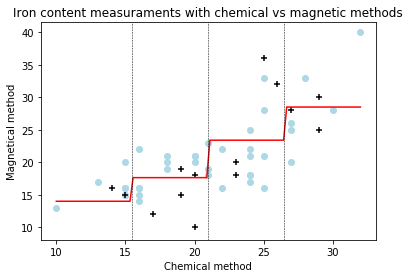

In [11]:
pw_model = PiecewiseModel(data, knots=knots)
pw_model.plot_base_data('train', color='lightblue', marker='o')
pw_model.plot_base_data('test', color='black', marker='+')
pw_model.plot_prediction_line()
pw_model.plot_knots()
_ = pw_model.get_error('train')
_ = pw_model.get_error('test')

### Splines

Now we can apply a basis function to capture the non-linearity of the data. Cubic splines are popular because most human eyes can't detect the discontinuity at the knots. We will also add the functionality to make it natural, wich adds additional boundary contraints, forcing to be a linear model at the boundaries. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.

In [12]:
class SplinesModel(PiecewiseModel):
    def __init__(self, data, fdata='x_train', degree=3, knots=(25, 50, 75), natural=False):
        self.natural = natural
        super().__init__(data, degree, knots)
        
    def create(self):
        formula = self.build_formula('self.x_train', self.degree, self.knots)
        x_transformed = dmatrix(formula, {'train': self.x_train}, return_type='dataframe')
        return sm.GLM(self.y_train, x_transformed).fit()    
    
    def predict(self, x):
        x = x.reshape(-1)
        formula = self.build_formula('x', self.degree, self.knots)
        mat = dmatrix(formula, {'valid': x}, return_type='dataframe')
        return self.model.predict(mat)
        
    def build_formula(self, data, degree, knots):
        if not self.natural:
            return 'bs({}, knots={}, degree={}, include_intercept=False)'.format(data, knots, degree)
        else:
            return 'cr({}, df={})'.format(data, len(knots))

RMSE in train data = 2.1297018495247184
RMSE in test data = 3.9453483653362262
-----
RMSE in train data = 1.7385056433080928
RMSE in test data = 2.517499815217831


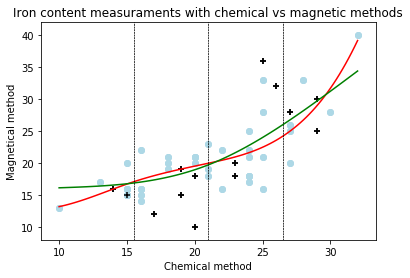

In [13]:
# Cubic Spline
spline_model = SplinesModel(data, knots=knots)
spline_model.plot_base_data('train', color='lightblue', marker='o')
spline_model.plot_base_data('test', color='black', marker='+')
spline_model.plot_prediction_line()
spline_model.plot_knots()
_ = spline_model.get_error('train')
_ = spline_model.get_error('test')

print('-----')

# Natural spline
spline_natural_model = SplinesModel(data, knots=knots, natural=True)
spline_natural_model.plot_base_data('train', color='lightblue', marker='o')
spline_natural_model.plot_base_data('test', color='black', marker='+')
spline_natural_model.plot_prediction_line(color='green')
spline_natural_model.plot_knots()
_ = spline_natural_model.get_error('train')
_ = spline_natural_model.get_error('test')